In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import pandas as pd
import re
import networkx as nx
import shapely
import geopandas as gpd

In [2]:
!pwd

/Users/glover.co/Documents/laszlo/NetDesign/notebooks/lego


In [3]:
colors = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/colors.csv',delimiter=',')
elements = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/elements.csv',delimiter=',')
inventories = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventories.csv',delimiter=',')
inventory_minifigs = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventory_minifigs.csv',delimiter=',')
inventory_parts = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventory_parts.csv',delimiter=',')
inventory_sets = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventory_sets.csv',delimiter=',')
minifigs = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/minifigs.csv',delimiter=',')
part_categories = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/part_categories.csv',delimiter=',')
part_relationships = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/part_relationships.csv',delimiter=',')
parts = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/parts.csv',delimiter=',')
sets = pd.read_csv(f'../../data/lego/rebrickable/sets.csv',delimiter=',')
themes = pd.read_csv(f'../../data/lego/rebrickable/themes.csv',delimiter=',')

In [4]:
def extract_sizes(name):
    match = re.search(r'(\d+)\s*[xX]\s*(\d+)(?:\s*[xX]\s*(\d+))?', name)
    if match:
        x, y, z = match.groups()
        return int(x), int(y), int(z) if z else 1  # Default z to 1
    return None, None, None 

In [5]:
parts[['x','y','z']] = parts['name'].apply(lambda name: pd.Series(extract_sizes(name)))

In [6]:
with open('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics/000012/info.json','r') as f:
    data =json.load(f)

In [7]:
df = pd.read_pickle('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics/000012/conns.pkl')

In [17]:
flattened_operations = []
for operation in data.get('operations', []):
    for brick in operation.get('bricks', []):
        # Check if canonical_state exists in the brick
        if 'canonical_state' in brick:
            # Merge the contents of canonical_state into the brick itself
            brick.update(brick.pop('canonical_state'))

AttributeError: 'str' object has no attribute 'get'

In [18]:
data

{'grid_size': [65, 65, 65],
 'operations': {'0': {'view_direction': [225, 30],
   'bricks': [{'brick_type': '3003',
     'color': [104, 195, 226],
     'op_type': 2,
     'brick_transform': {'position': [0.0, 0, 0.0],
      'rotation': [0.7071067811865476, 0.0, -0.7071067811865475, 0.0],
      'rotation_euler': [0, -90, 0],
      'keypoint_brick': [256, 398, 0]},
     'mask': {'size': [512, 512],
      'counts': '^\\_31o?1N100O2O0O2O1N101N1O2O0O2O001N101N101N100O2O0O2O1N101N1O2O001N101Oj0VOO101N100O2O1N2O0O2O0O2O0O2O0O2O0O2O0O101N100O2O1N2O0O2O0O2O0O2O0O2OaS^3'},
     'bbox': [[222, 382], [290, 441]],
     'mask_pixel_count': 2107},
    {'brick_type': '3660',
     'color': [104, 195, 226],
     'op_type': 2,
     'brick_transform': {'position': [0.0, 0.0, -2.0],
      'rotation': [1.1102230246251565e-16, 0.0, -0.9999999999999999, 0.0],
      'rotation_euler': [180, 0, 180],
      'keypoint_brick': [221, 415, 0]},
     'mask': {'size': [512, 512],
      'counts': 'Pmm25j?2O0O2O1N2O0O2O1

In [69]:
print(data['operations']['11'])

{'view_direction': [225, 30], 'bricks': [{'canonical_state': {'cls': 'CBrick', 'bricks_pc': {'operations': {'0': {'bricks': [{'brick_type': '2877', 'canonical_position': [0.0, 0.0, 0.0], 'canonical_rotation': [0.7071067811865474, -0.0, 0.7071067811865477, -0.0], 'op_type': 2}]}, '1': {'bricks': [{'brick_type': '3005', 'canonical_position': [0.0, 3.0, -0.5], 'canonical_rotation': [0.7071067811865475, 0.0, -0.7071067811865475, 0.0], 'op_type': 0}]}, '2': {'bricks': [{'brick_type': '3005', 'canonical_position': [0.0, 3.0, 0.5], 'canonical_rotation': [0.7071067811865475, 0.0, -0.7071067811865475, 0.0], 'op_type': 0}]}, '3': {'bricks': [{'brick_type': '3004', 'canonical_position': [0.0, 6.0, 0.0], 'canonical_rotation': [0.7071067811865475, 0.0, -0.7071067811865475, 0.0], 'op_type': 0}]}, '4': {'bricks': [{'brick_type': '3040b', 'canonical_position': [0.0, 9.0, 0.0], 'canonical_rotation': [1.1102230246251568e-16, -0.0, -1.0, -0.0], 'op_type': 0}]}}, 'grid_size': [65, 65, 65]}, 'position': [-

In [70]:
brick_part_names = []
positions = []
rotations = []

In [8]:
steps = data['operations'].keys()
for s in steps:
    bricks = data['operations'][s]['bricks']
    for b in bricks:
        try:
            brick_part_names.append(b['brick_type'])
            positions.append(b['brick_transform']['position'])
            rotations.append(b['brick_transform']['rotation'])
        except:
            canonical_state = b['canonical_state']['bricks_pc']
            canonical_steps = canonical_state['operations'].keys()
            true_positions = b['brick_transform']['position']
            for t in canonical_steps:
                canonical_bricks = canonical_state['operations'][t]['bricks']
                for c in canonical_bricks:
                    brick_part_names.append(c['brick_type'])
                    new_position = np.array(c['canonical_position']) + np.array(true_positions)
                    positions.append(list(new_position))
                    rotations.append(c['canonical_rotation'])

KeyError: 'canonical_state'

In [80]:
np.cos(np.arctan2(rotations[0][2],rotations[0][0]))

0.7071067811865477

In [78]:
rotations[0][0]

0.7071067811865476

In [34]:
data['operations']['11']['bricks'][0]['canonical_state']['bricks_pc']['operations']

{'0': {'bricks': [{'brick_type': '2877',
    'canonical_position': [0.0, 0.0, 0.0],
    'canonical_rotation': [0.7071067811865474, -0.0, 0.7071067811865477, -0.0],
    'op_type': 2}]},
 '1': {'bricks': [{'brick_type': '3005',
    'canonical_position': [0.0, 3.0, -0.5],
    'canonical_rotation': [0.7071067811865475, 0.0, -0.7071067811865475, 0.0],
    'op_type': 0}]},
 '2': {'bricks': [{'brick_type': '3005',
    'canonical_position': [0.0, 3.0, 0.5],
    'canonical_rotation': [0.7071067811865475, 0.0, -0.7071067811865475, 0.0],
    'op_type': 0}]},
 '3': {'bricks': [{'brick_type': '3004',
    'canonical_position': [0.0, 6.0, 0.0],
    'canonical_rotation': [0.7071067811865475, 0.0, -0.7071067811865475, 0.0],
    'op_type': 0}]},
 '4': {'bricks': [{'brick_type': '3040b',
    'canonical_position': [0.0, 9.0, 0.0],
    'canonical_rotation': [1.1102230246251568e-16, -0.0, -1.0, -0.0],
    'op_type': 0}]}}

In [62]:
def make_lego_network(data,brick_height=3,brick_unit=.5,part_info=parts,pos_order = [0,2,1]):
    # Get brick_types
    brick_part_names = []
    positions = []
    rotations = []
    euler_rotations = []
    steps = data['operations'].keys()
    for s in steps:
        bricks = data['operations'][s]['bricks']
        for b in bricks:
            try:
                brick_part_names.append(b['brick_type'])
                positions.append(b['brick_transform']['position'])
                rotations.append(b['brick_transform']['rotation'])
                euler_rotations.append(b['brick_transform']['rotation_euler'])
            except:
                canonical_state = b['canonical_state']['bricks_pc']
                canonical_steps = canonical_state['operations'].keys()
                true_positions = b['brick_transform']['position']
                for t in canonical_steps:
                    canonical_bricks = canonical_state['operations'][t]['bricks']
                    for c in canonical_bricks:
                        new_position = np.array(c['canonical_position']) + np.array(true_positions)
                        positions.append(list(new_position))
                        rotations.append(c['canonical_rotation'])
                        
    # Initialize label matrix
    num_bricks = len(set(brick_part_names))
    positions = np.array(positions)
    positions = positions[:,pos_order]
    rotations = np.array(rotations)[:,:-1]
    rotations = rotations[:,pos_order]
    angles = np.arctan2(rotations[:,1],rotations[:,0])
    N = positions.shape[0]
    X = np.zeros((N,num_bricks))
    
    # Initialize network
    g = nx.Graph()
    
    for j,b in enumerate(brick_part_names):
        fig, ax = plt.subplots()
        brick_sizes = []
        # Add node
        g.add_node(g.number_of_nodes())
        node_idx = g.number_of_nodes()-1

        # Make bounding box of brick
        cur_brick = brick_part_names[node_idx]
        # Get size
        brick_x, brick_y, brick_z = part_info[part_info['part_num'] == cur_brick][['x','y','z']].values[0]
        brick_x *= brick_unit
        brick_y *= brick_unit
        brick_z *= brick_height

        p0 = (positions[node_idx,0] + brick_x, positions[node_idx,1] + brick_y)
        p1 = (positions[node_idx,0] + brick_x, positions[node_idx,1] - brick_y)
        p2 = (positions[node_idx,0] - brick_x, positions[node_idx,1] - brick_y)
        p3 = (positions[node_idx,0] - brick_x, positions[node_idx,1] + brick_y)
        brick_sizes.append([brick_x,brick_y])

        angles[np.abs(np.round(angles*180/np.pi)) == 45] = 0
        # Make shapely box
        brick_box = shapely.Polygon((p0,p1,p2,p3))
        brick_box = shapely.affinity.rotate(brick_box,angle = angles[node_idx]*180/np.pi,use_radians=False,origin=(positions[node_idx,0],positions[node_idx,1]))
        ax.plot(*brick_box.exterior.xy)

        g.nodes[node_idx]['box'] = brick_box
        g.nodes[node_idx]['top'] = brick_z + positions[node_idx,2]
        for node in range(node_idx):
            # Check for connection
            new_height = g.nodes[node]['top']
            if new_height == positions[node_idx,2] or positions[node,2] == g.nodes[node_idx]['top']:
                new_brick = g.nodes[node]['box']
                if new_brick.overlaps(brick_box):
                    g.add_edge(node,node_idx)
                
        ax.set_title(f'{angles[node_idx]*180/np.pi}')
        plt.axis(xmin=-3,xmax=3,ymin=-3,ymax=3)
        plt.show()
    return g, X, positions, rotations,angles, euler_rotations#, rotations

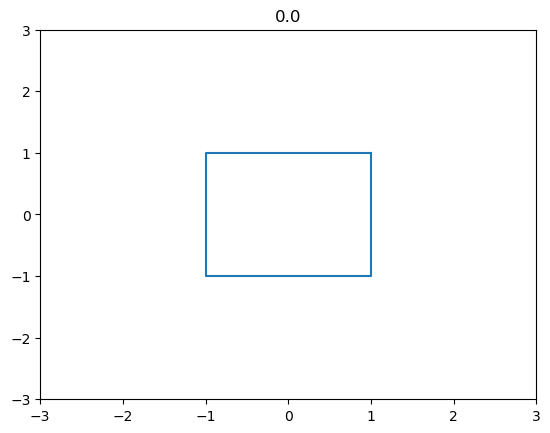

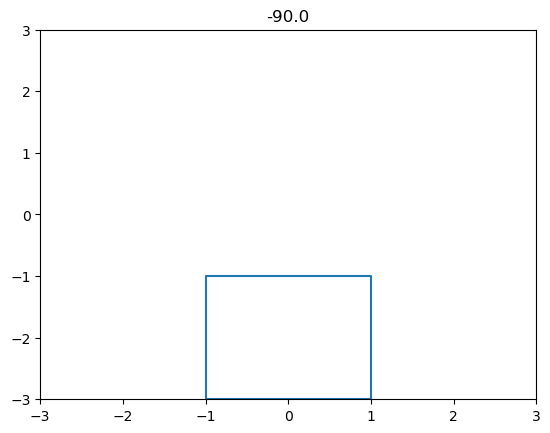

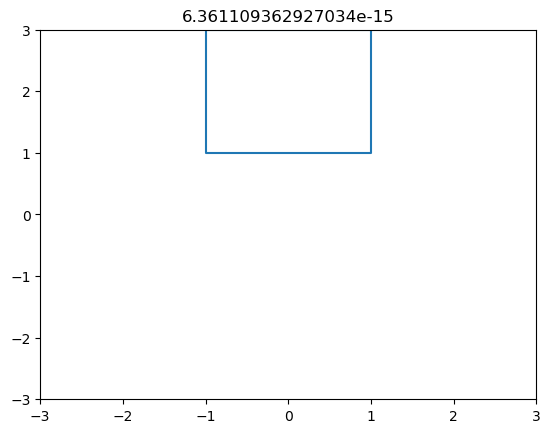

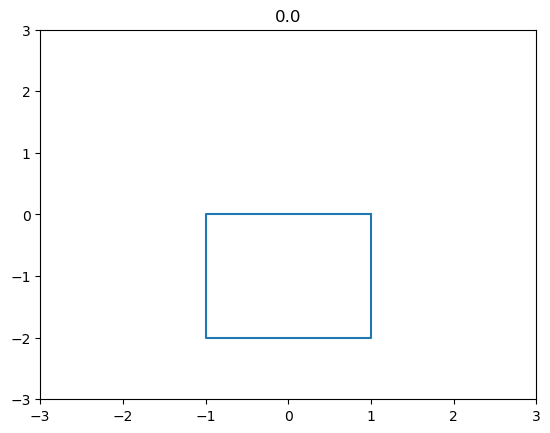

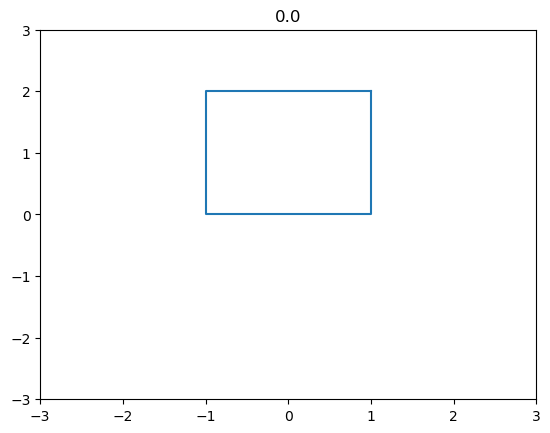

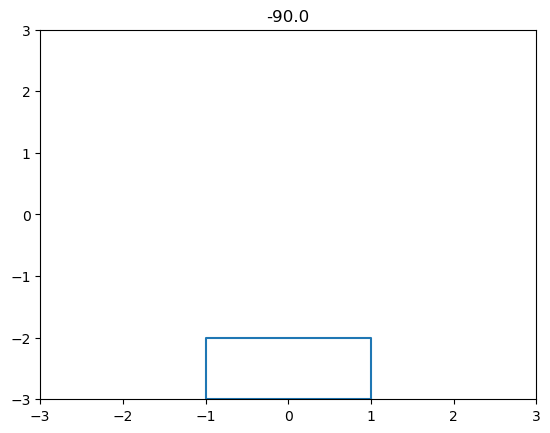

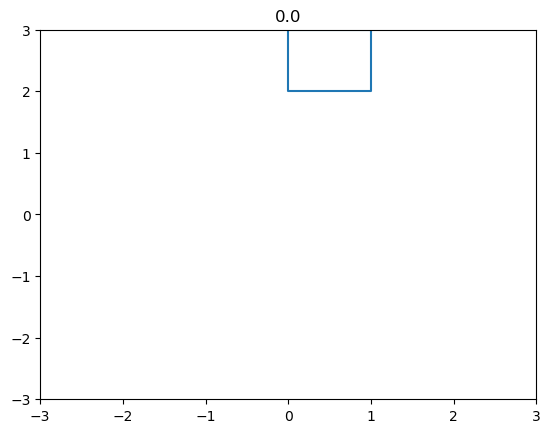

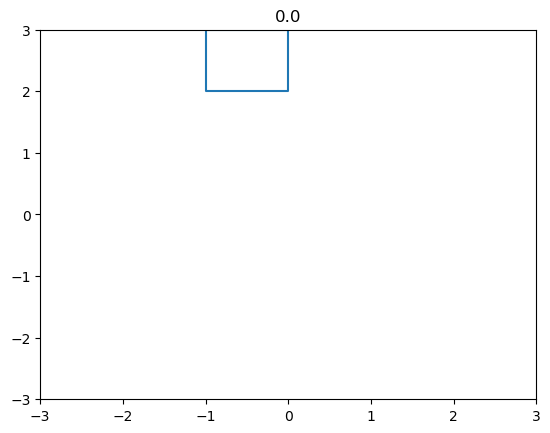

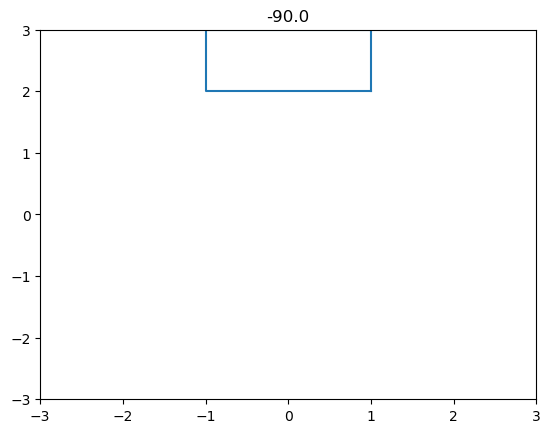

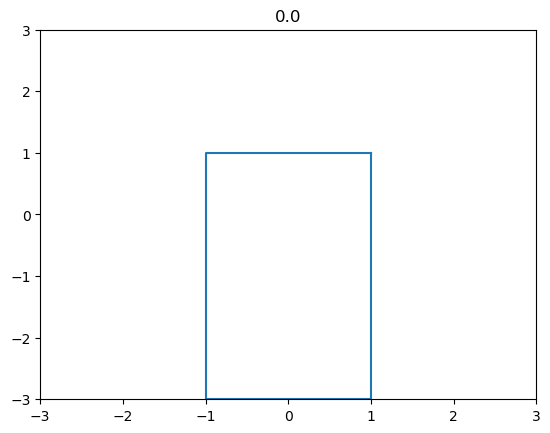

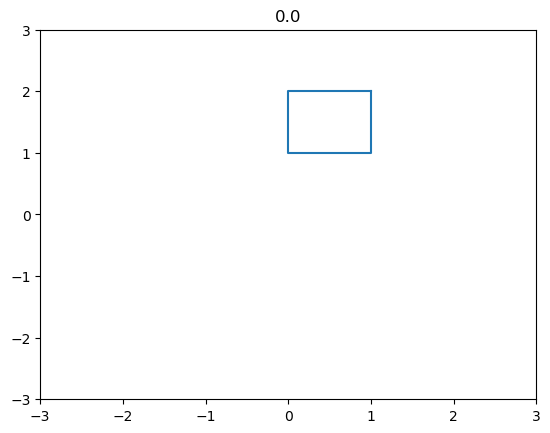

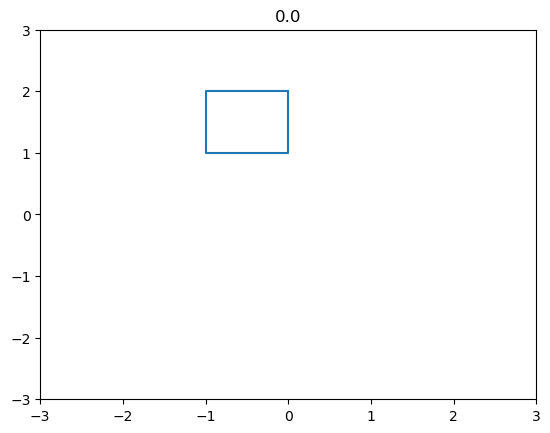

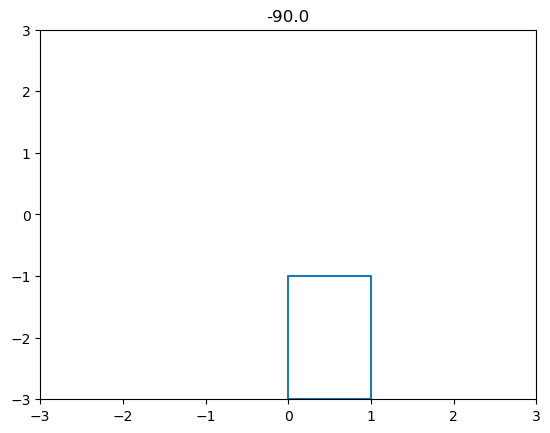

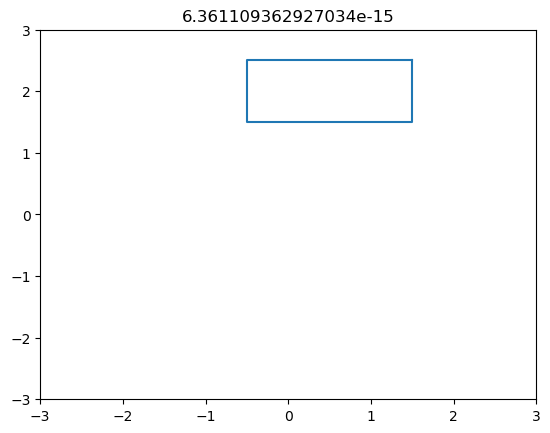

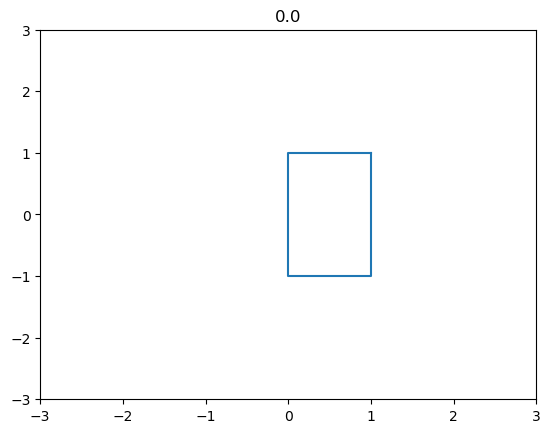

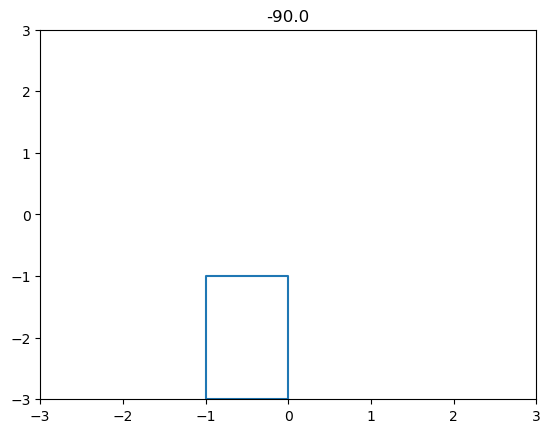

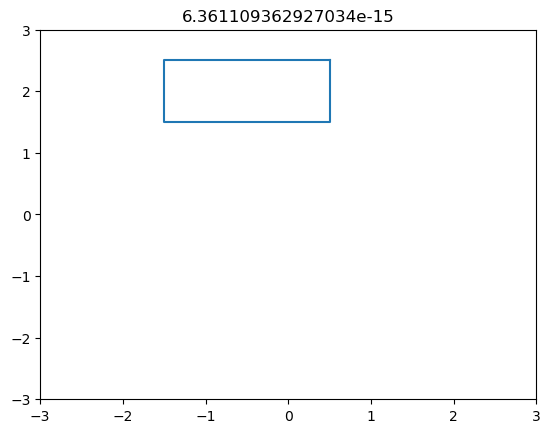

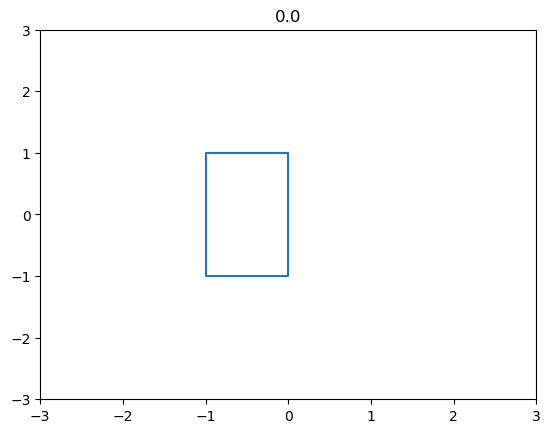

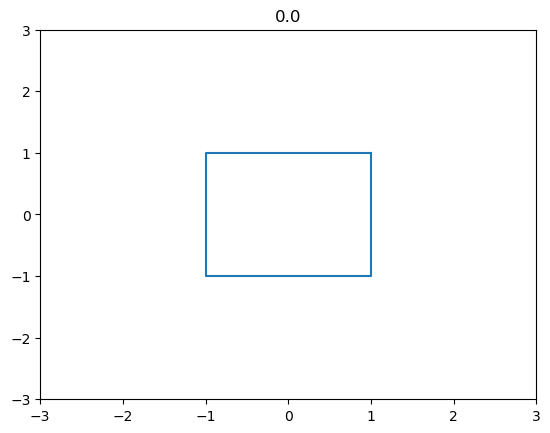

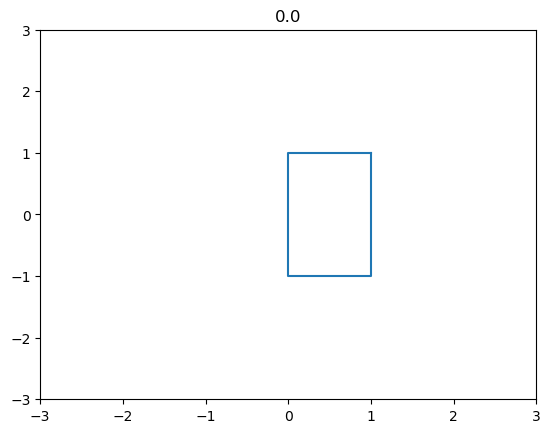

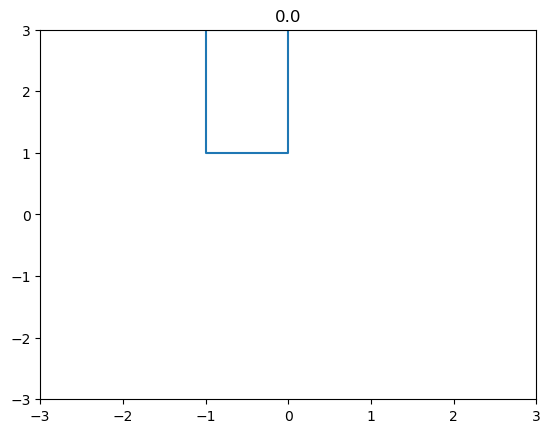

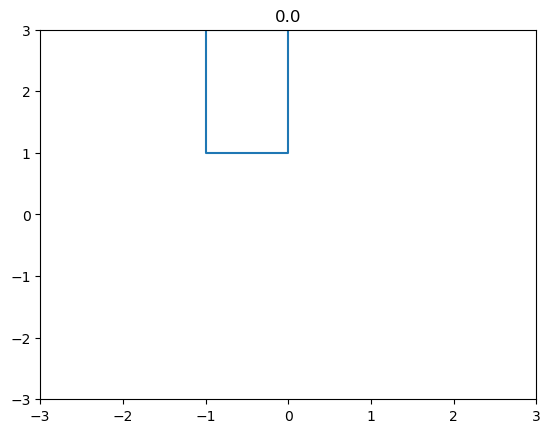

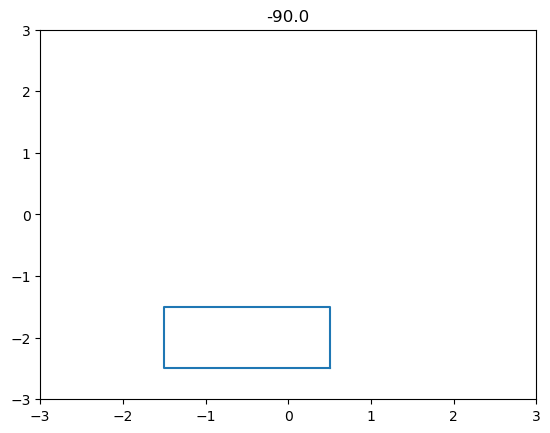

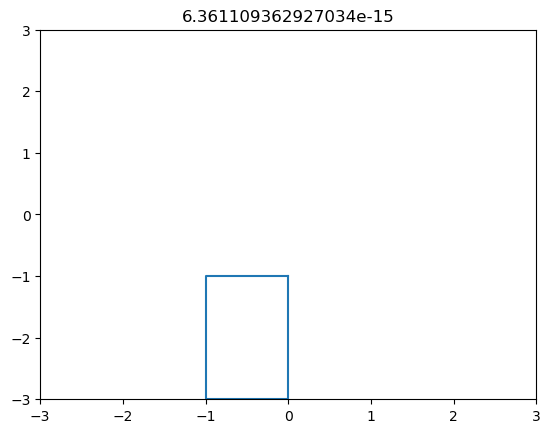

In [63]:
g, X, positions,rotations,angles,euler_rotations = make_lego_network(data)

In [64]:
positions

array([[ 0. ,  0. ,  0. ],
       [ 0. , -2. ,  0. ],
       [ 0. ,  2. ,  0. ],
       [ 0. , -1. ,  3. ],
       [ 0. ,  1. ,  3. ],
       [ 0. , -2.5,  3. ],
       [ 0.5,  2.5,  3. ],
       [-0.5,  2.5,  3. ],
       [-0. ,  2.5,  6. ],
       [ 0. , -1. ,  6. ],
       [ 0.5,  1.5,  6. ],
       [-0.5,  1.5,  6. ],
       [ 0.5, -2. ,  9. ],
       [ 0.5,  2. ,  9. ],
       [ 0.5,  0. ,  9. ],
       [-0.5, -2. ,  9. ],
       [-0.5,  2. ,  9. ],
       [-0.5,  0. ,  9. ],
       [ 0. ,  0. , 12. ],
       [ 0.5,  0. , 15. ],
       [-0.5,  2. , 12. ],
       [-0.5,  2. , 15. ],
       [-0.5, -2. , 12. ],
       [-0.5, -2. , 15. ],
       [-0.5,  0. , 15. ],
       [-0.5,  0. , 18. ],
       [-0.5,  0. , 21. ],
       [-0.5,  0. , 24. ],
       [-0.5,  0. , 27. ],
       [-0.5, -0.5, 30. ],
       [-0.5,  0.5, 30. ],
       [-0.5,  0. , 33. ],
       [-0.5,  0. , 36. ]])

In [241]:
ldr_data = []
with open('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics_lpub3d/000012/model.ldr','r') as f:
    for line in f:
        ldr_data.append(line.strip())

In [242]:
len(bricks)

33

In [244]:
brick_names = []
positions = []
rotations = []
for l in ldr_data:
    if l != '':
        if l[0] == '1':
            if l[-1] != 'r':
                brick = l.split(' ')
                brick_names.append(brick[-1][:-4])
                positions.append(brick[2:5])
                rotations.append(np.array(brick[5:-1],dtype=float).reshape(3,3))
positions = np.array(positions,dtype=float)


In [259]:
np.dot(rotations[0],parse_ldraw_dat('/Users/glover.co/Downloads/ldraw/parts/3003.dat')[0].T).T#+ positions[0],positions[0]

array([[-20.,  24., -20.],
       [ 20.,  24., -20.],
       [ 20.,   0., -20.],
       [-20.,   0., -20.]])

In [392]:
def extract_ldr_info(file):
    """
    Extract names, positions and rotations from LDR file.
    """
    ldr_data = []
    with open(file,'r') as f:
        for line in f:
            ldr_data.append(line.strip())

    brick_names = []
    positions = []
    rotations = []
    for l in ldr_data:
        if l != '':
            if l[0] == '1':
                if l[-1] != 'r':
                    brick = l.split(' ')
                    brick_names.append(brick[-1][:-4])
                    positions.append(brick[2:5])
                    rotations.append(np.array(brick[5:-1],dtype=float).reshape(3,3))
    positions = np.array(positions,dtype=float)
    return brick_names, positions, rotations

def parse_ldraw_dat(file):
    part_info = []
    vertices = []
    edges = []
    faces = []
    
    # Get first line of file
    with open(file,'r') as f:
        first_line = f.readline().strip()
    check = '0 ~Moved to '
    if first_line[:len(check)] == check:
        file = f'/Users/glover.co/Downloads/ldraw/parts/{first_line[len(check):]}.dat'

    with open(file,'r') as f:
        for line in f:
            parts = line.strip().split()
        
            if not parts or parts[0] == '0':
                continue

            command_type = parts[0]
            if command_type == '2':  # Edge line
                v1 = tuple(map(float, parts[2:5]))  # First vertex (x, y, z)
                v2 = tuple(map(float, parts[5:8]))  # Second vertex
                if v1 not in vertices:
                    vertices.append(v1)
                if v2 not in vertices:
                    vertices.append(v2)
                edges.append((v1, v2))

            elif command_type == '3':  # Triangle face
                v1 = tuple(map(float, parts[2:5]))
                v2 = tuple(map(float, parts[5:8]))
                v3 = tuple(map(float, parts[8:11]))
                if v1 not in vertices:
                    vertices.append(v1)
                if v2 not in vertices:
                    vertices.append(v2)
                if v3 not in vertices:
                    vertices.append(v3)
                faces.append((v1, v2, v3))

            elif command_type == '4':  # Quad face
                v1 = tuple(map(float, parts[2:5]))
                v2 = tuple(map(float, parts[5:8]))
                v3 = tuple(map(float, parts[8:11]))
                v4 = tuple(map(float, parts[11:14]))
                if v1 not in vertices:
                    vertices.append(v1)
                if v2 not in vertices:
                    vertices.append(v2)
                if v3 not in vertices:
                    vertices.append(v3)
                if v4 not in vertices:
                    vertices.append(v4)
                faces.append((v1, v2, v3, v4))
    
    # Convert to numpy for easy calculations
    vertices = np.array(vertices)
    
    # Center the part around the origin by shifting it to its own bounding box center
    if len(vertices) > 0:
        min_corner, max_corner = get_bounding_box(vertices)
        center = (np.array(min_corner) + np.array(max_corner)) / 2
        vertices -= center  # Shift all vertices to center around (0,0,0)
    
    return vertices, edges, faces

    return vertices, edges, faces

def get_bounding_box(vertices):
    """
    Computes the 3D bounding box of a LEGO part.
    """
    min_x, min_y, min_z = np.min(vertices, axis=0)
    max_x, max_y, max_z = np.max(vertices, axis=0)
    
    return (min_x, min_y, min_z), (max_x, max_y, max_z)

def check_brick_contact(box1, box2, vertical_tolerance=12.0):
    """
    Determines if two bricks are stacked on top of each other.
    """
    (min1, min1_y, min1_z), (max1, max1_y, max1_z) = box1
    (min2, min2_y, min2_z), (max2, max2_y, max2_z) = box2

    xy_overlap_x = (min1 <= max2) and (max1 >= min2)
    xy_overlap_y = (min1_z <= max2_z) and (max1_z >= min2_z)
    xy_overlap = xy_overlap_x and xy_overlap_y  # X-Y overlap check
    z_stacked = abs(min1_y - min2_y) <= vertical_tolerance and abs(min1_y-min2_y) > 0 # Stacked in Z
    print(abs(min1_y - min2_y))
    return xy_overlap and z_stacked

def apply_rotation(vertices, rotation_matrix, position):
    """
    Rotates and translates the brick's vertices.
    """
    rotated = (rotation_matrix @ vertices.T).T  # Rotate
    return rotated + position  # Translate

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_bounding_box(ax, bbox, color='r'):
    """
    Draw a 3D bounding box on the given matplotlib 3D axis.
    
    Parameters:
        ax: matplotlib 3D axis
        bbox: ((min_x, min_y, min_z), (max_x, max_y, max_z))
        color: Color of the bounding box
    """
    (min_x, min_y, min_z), (max_x, max_y, max_z) = bbox

    # Define the 8 corners of the bounding box
    corners = np.array([
        [min_x, min_y, min_z], [max_x, min_y, min_z],
        [max_x, max_y, min_z], [min_x, max_y, min_z],
        [min_x, min_y, max_z], [max_x, min_y, max_z],
        [max_x, max_y, max_z], [min_x, max_y, max_z]
    ])

    # Define the 12 edges of the bounding box
    edges = [
        [corners[0], corners[1]], [corners[1], corners[2]], [corners[2], corners[3]], [corners[3], corners[0]],  # Bottom face
        [corners[4], corners[5]], [corners[5], corners[6]], [corners[6], corners[7]], [corners[7], corners[4]],  # Top face
        [corners[0], corners[4]], [corners[1], corners[5]], [corners[2], corners[6]], [corners[3], corners[7]]   # Side edges
    ]

    # Draw edges
    for edge in edges:
        ax.plot3D(*zip(*edge), color=color)

    # Fill the bounding box with transparent faces
    faces = [
        [corners[0], corners[1], corners[2], corners[3]],  # Bottom face
        [corners[4], corners[5], corners[6], corners[7]],  # Top face
        [corners[0], corners[1], corners[5], corners[4]],  # Side faces
        [corners[2], corners[3], corners[7], corners[6]],
        [corners[1], corners[2], corners[6], corners[5]],
        [corners[4], corners[7], corners[3], corners[0]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, alpha=0.2, facecolor=color))
    # plt.show()

def plot_lego_model(file):
    """
    Plots the bounding boxes of all bricks in the LEGO model.
    """
    names, positions, rotations = extract_ldr_info(file)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, brick_name in enumerate(names):
        # Load part geometry
        vertices, _, _ = parse_ldraw_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick_name}.dat')

        # Transform vertices
        rotated_vertices = apply_rotation(np.array(vertices), rotations[i], positions[i])

        # Compute bounding box
        bbox = get_bounding_box(rotated_vertices)

        # Draw bounding box
        draw_bounding_box(ax, bbox, color=np.random.rand(3,))

    # Set axis labels
    ax.set_xlim(-60, 60)
    # ax.set_ylim(-60, 60)
    ax.set_zlim(-60, 60)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Bounding Boxes of LEGO Model")
    
    plt.show()




def lego_network(file):
    # Extract LDraw information
    names, positions, rotations = extract_ldr_info(file)
    g = nx.Graph()

    # bounding_boxes = []  # Store bounding boxes for stacking checks

    for i, brick_name in enumerate(names):
        # Add node to graph
        g.add_node(i, name=brick_name)

        # Load part geometry
        vertices, edges, faces = parse_ldraw_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick_name}.dat')

        # Transform geometry
        rotated_vertices = apply_rotation(np.array(vertices), rotations[i], positions[i])

        # Compute bounding box
        bbox = get_bounding_box(rotated_vertices)
        g.nodes[i]['bbox'] = bbox
        # fig = plt.figure(figsize=(10, 8))
        # ax = fig.add_subplot(111, projection='3d')
        # draw_bounding_box(ax, bbox)
        # Check for stacking with previous bricks
        for j in range(i):
            if check_brick_contact(bbox, g.nodes[j]['bbox']):
                g.add_edge(i, j)  # Stack connection
        nx.draw(g,with_labels=True)
        plt.title(brick_name)
        plt.show()

    return g

# def lego_network(file, part_info=parts):
#     # Get info from LDR file
#     names, positions, rotations = extract_ldr_info(file)

#     # Initialize network
#     g = nx.Graph()

#     for i, brick_name in enumerate(names):
#         fig, ax = plt.subplots()
#         # Add brick
#         g.add_node(i)
#         # Add node attributes
#         g.nodes[i]['name'] = brick_name

#         # Make shapely box
#         # brick_x, brick_y, brick_z = part_info[part_info['part_num'] == brick_name][['x','y','z']].values[0]
#         # brick_x *= 16/2
#         # brick_y *= 16/2
#         # brick_z = 24
#         rot_matrix = rotations[i]
#         vertices, edges, faces = parse_ldraw_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick_name}.dat')
#         # vertices = [(brick_x,brick_y),(brick_x,-brick_y),(-brick_x,-brick_y),(-brick_x,brick_y)]
#         rotated_vertices = (rot_matrix@vertices.T).T
#         final_vertices = rotated_vertices + positions[i]
#         box = get_bounding_box(vertices)

#         # Print vertices of box
#         g.nodes[i]['box'] = box
#         # ax.plot(*g.nodes[i]['box'].exterior.xy)
#         for node in range(i):
#             box2 = g.nodes[node]['box']
#             if check_brick_contact(box,box2):
#                 g.add_edge(node,i)
        
#         ax.set_title(f'Brick {i}')
#         plt.axis(xmin=-60,xmax=60,ymin=-60,ymax=60)
#         plt.show()
#     return g

        
        

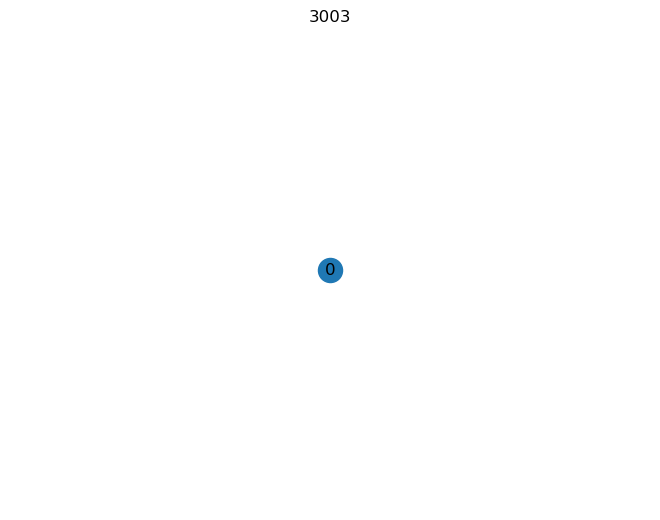

2.0


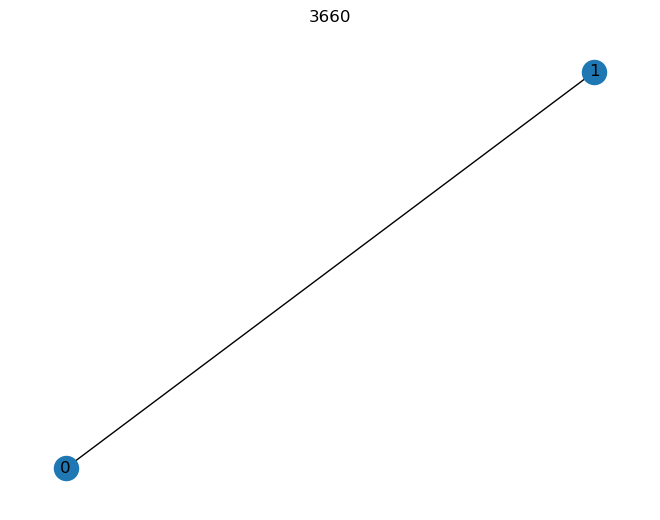

2.0
0.0


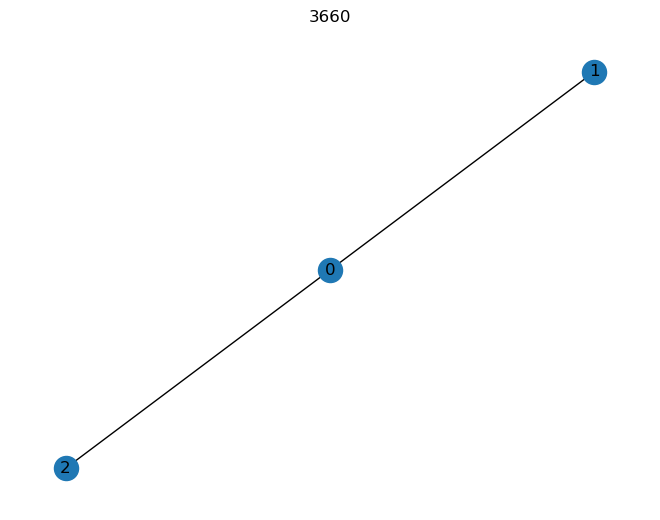

24.0
26.0
26.0


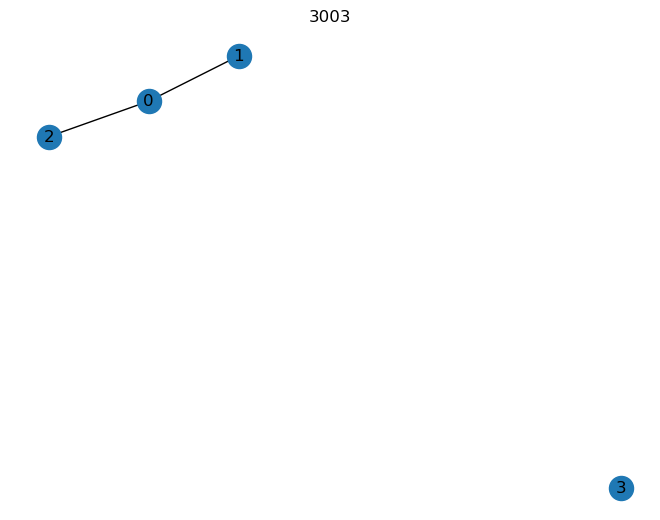

24.0
26.0
26.0
0.0


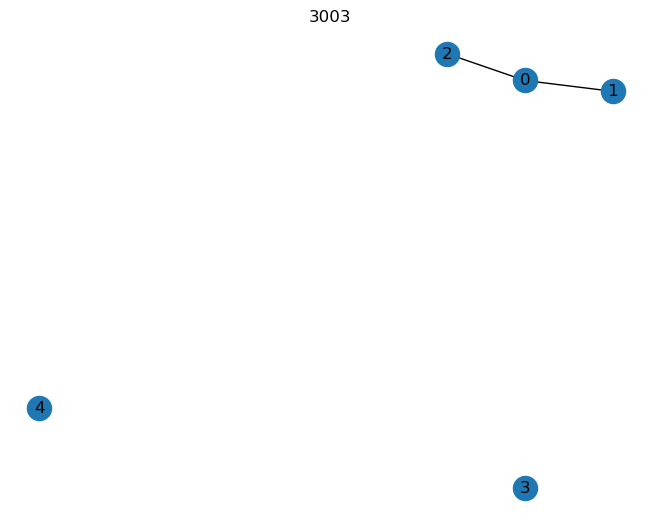

24.0
26.0
26.0
0.0
0.0


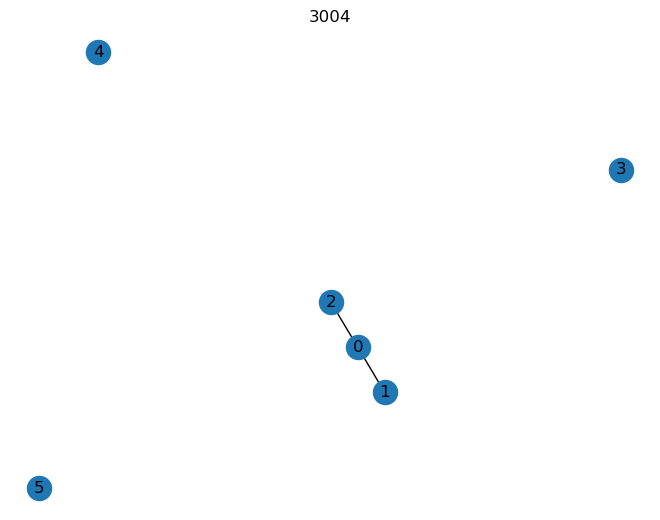

24.0
26.0
26.0
0.0
0.0
0.0


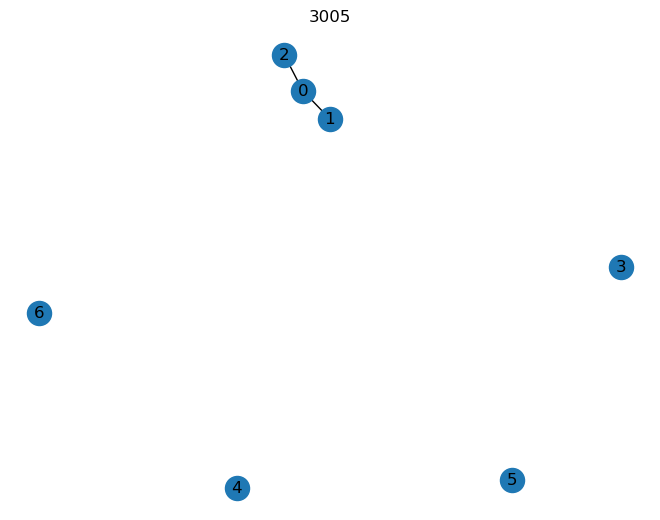

24.0
26.0
26.0
0.0
0.0
0.0
0.0


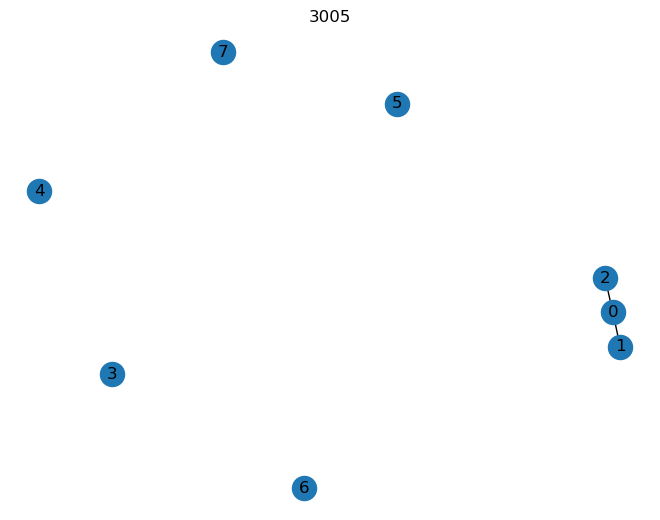

48.0
50.0
50.0
24.0
24.0
24.0
24.0
24.0


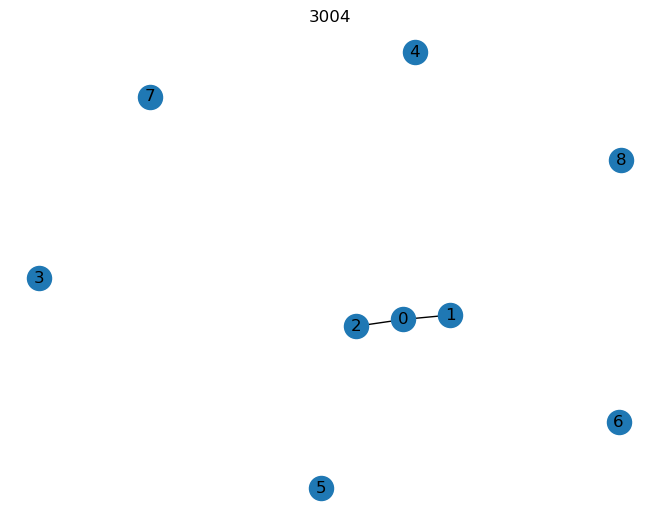

48.0
50.0
50.0
24.0
24.0
24.0
24.0
24.0
0.0


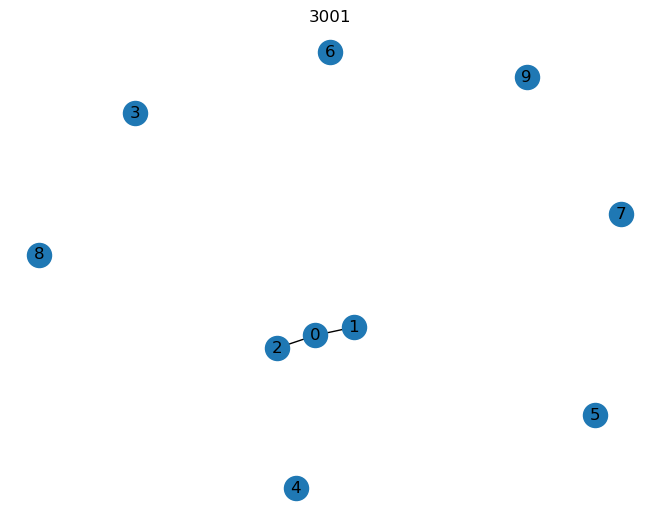

48.0
50.0
50.0
24.0
24.0
24.0
24.0
24.0
0.0
0.0


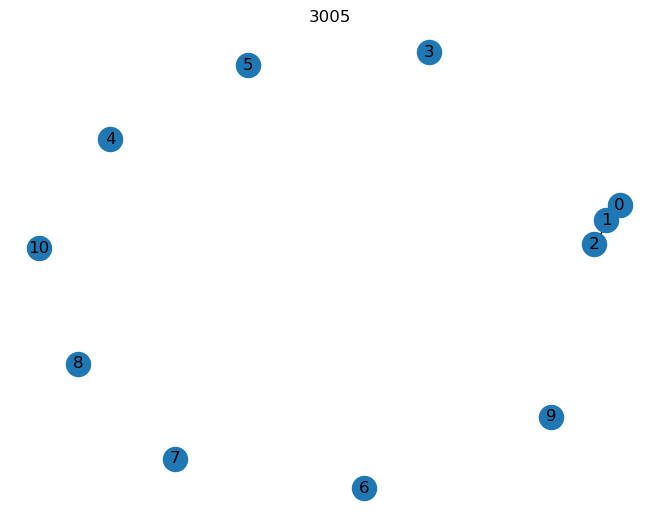

48.0
50.0
50.0
24.0
24.0
24.0
24.0
24.0
0.0
0.0
0.0


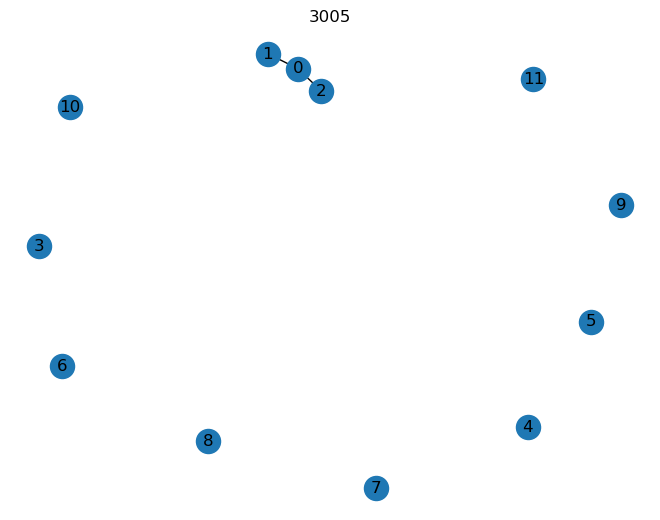

70.0
72.0
72.0
46.0
46.0
46.0
46.0
46.0
22.0
22.0
22.0
22.0


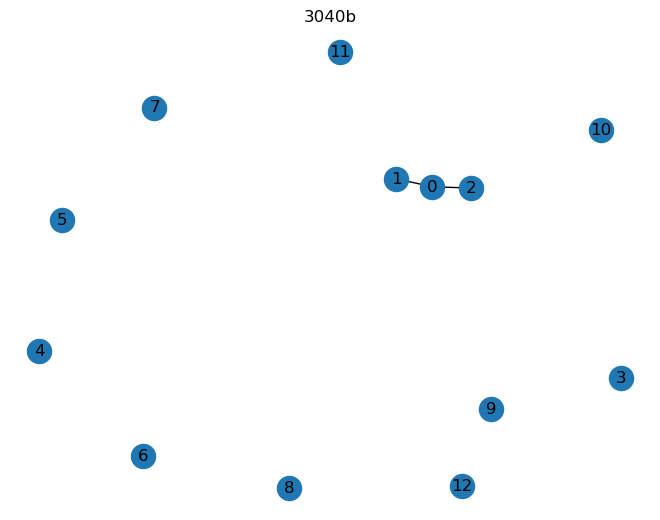

70.0
72.0
72.0
46.0
46.0
46.0
46.0
46.0
22.0
22.0
22.0
22.0
0.0


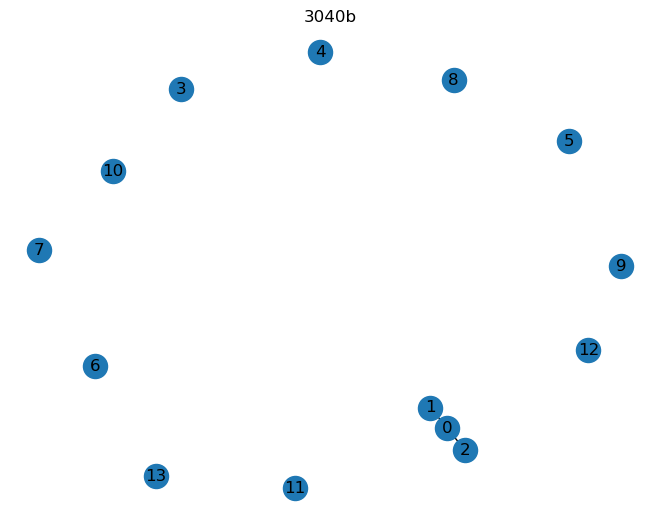

72.0
74.0
74.0
48.0
48.0
48.0
48.0
48.0
24.0
24.0
24.0
24.0
2.0
2.0


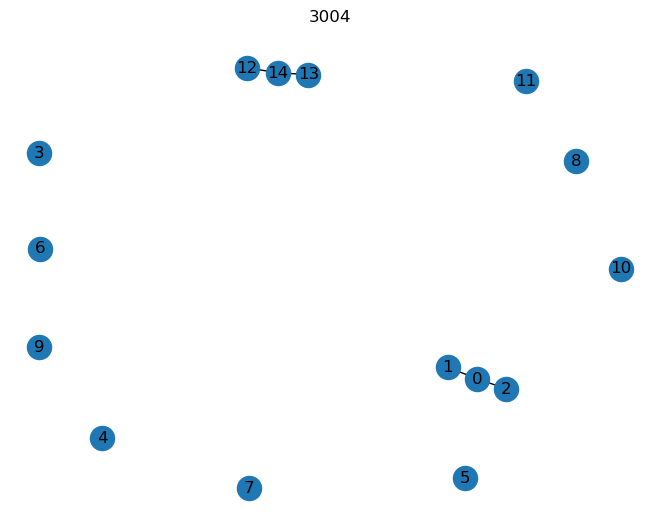

70.0
72.0
72.0
46.0
46.0
46.0
46.0
46.0
22.0
22.0
22.0
22.0
0.0
0.0
2.0


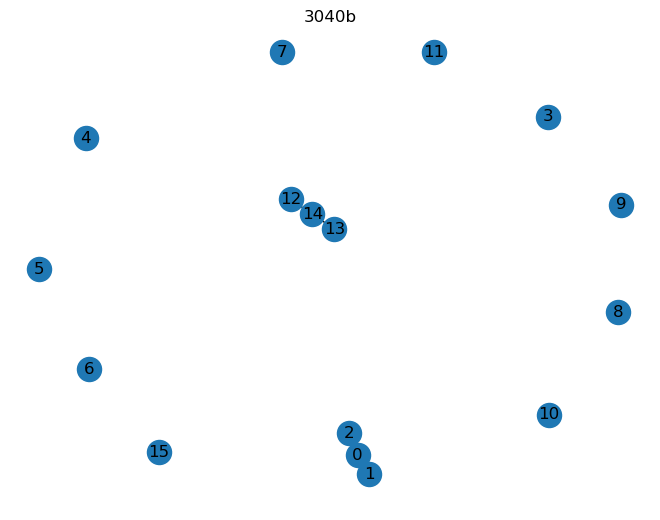

70.0
72.0
72.0
46.0
46.0
46.0
46.0
46.0
22.0
22.0
22.0
22.0
0.0
0.0
2.0
0.0


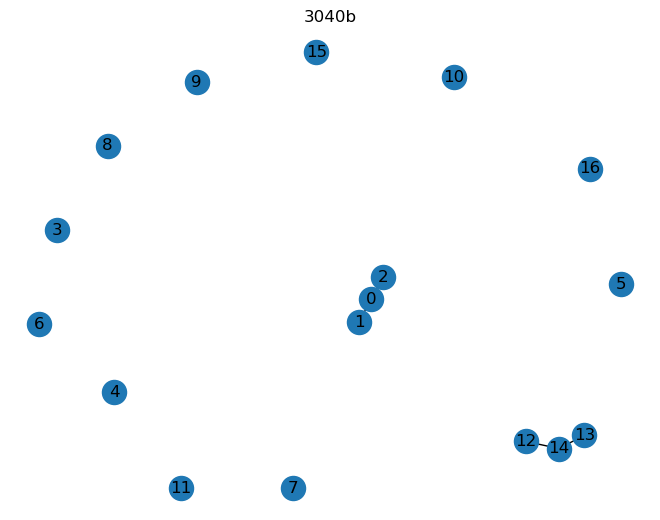

72.0
74.0
74.0
48.0
48.0
48.0
48.0
48.0
24.0
24.0
24.0
24.0
2.0
2.0
0.0
2.0
2.0


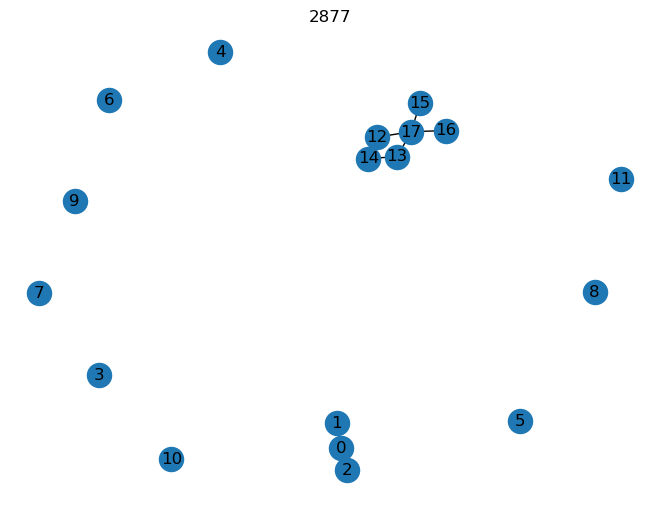

96.0
98.0
98.0
72.0
72.0
72.0
72.0
72.0
48.0
48.0
48.0
48.0
26.0
26.0
24.0
26.0
26.0
24.0


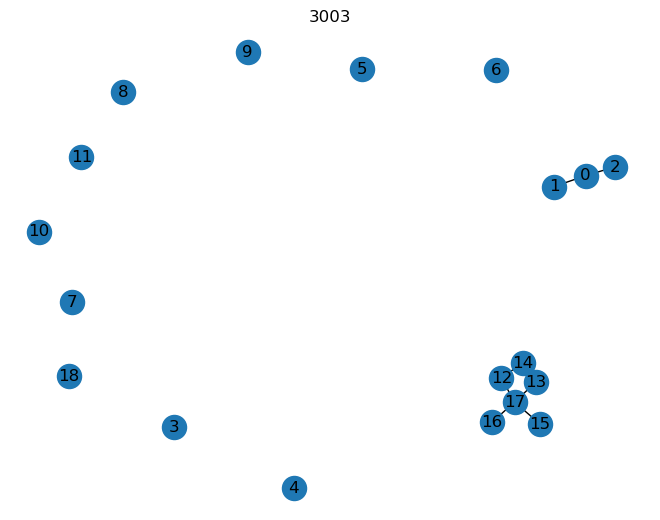

89.8
91.8
91.8
65.8
65.8
65.8
65.8
65.8
41.8
41.8
41.8
41.8
19.799999999999997
19.799999999999997
17.799999999999997
19.799999999999997
19.799999999999997
17.799999999999997
6.200000000000003


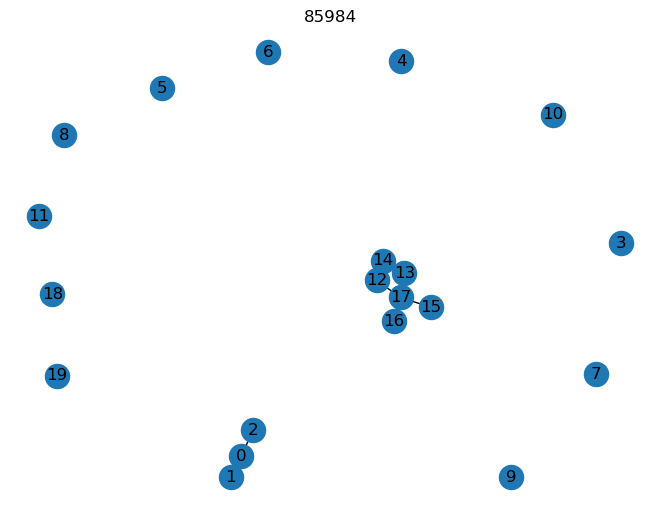

120.0
122.0
122.0
96.0
96.0
96.0
96.0
96.0
72.0
72.0
72.0
72.0
50.0
50.0
48.0
50.0
50.0
48.0
24.0
30.200000000000003


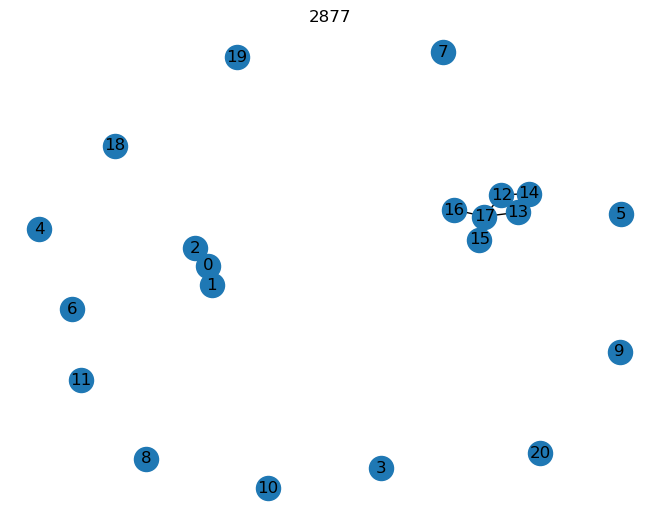

144.0
146.0
146.0
120.0
120.0
120.0
120.0
120.0
96.0
96.0
96.0
96.0
74.0
74.0
72.0
74.0
74.0
72.0
48.0
54.2
24.0


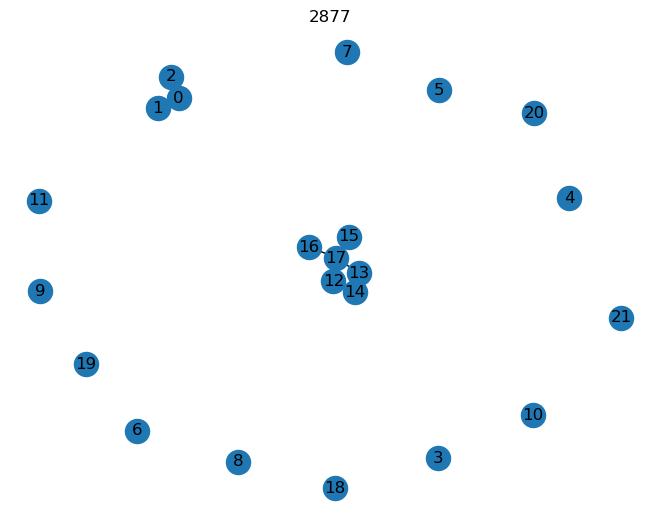

168.0
170.0
170.0
144.0
144.0
144.0
144.0
144.0
120.0
120.0
120.0
120.0
98.0
98.0
96.0
98.0
98.0
96.0
72.0
78.2
48.0
24.0


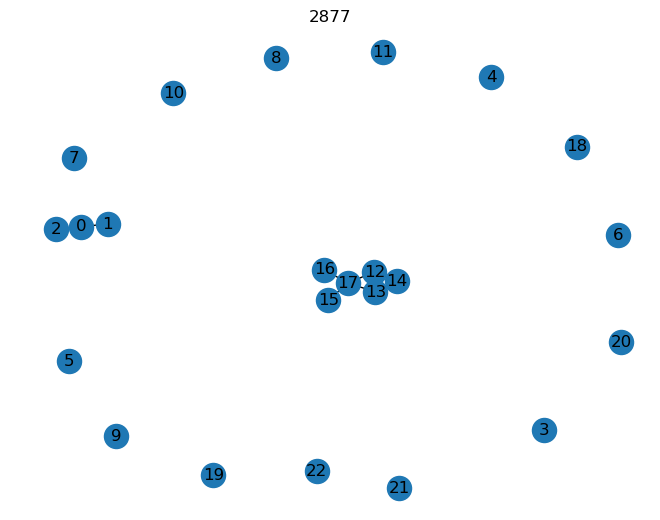

192.0
194.0
194.0
168.0
168.0
168.0
168.0
168.0
144.0
144.0
144.0
144.0
122.0
122.0
120.0
122.0
122.0
120.0
96.0
102.2
72.0
48.0
24.0


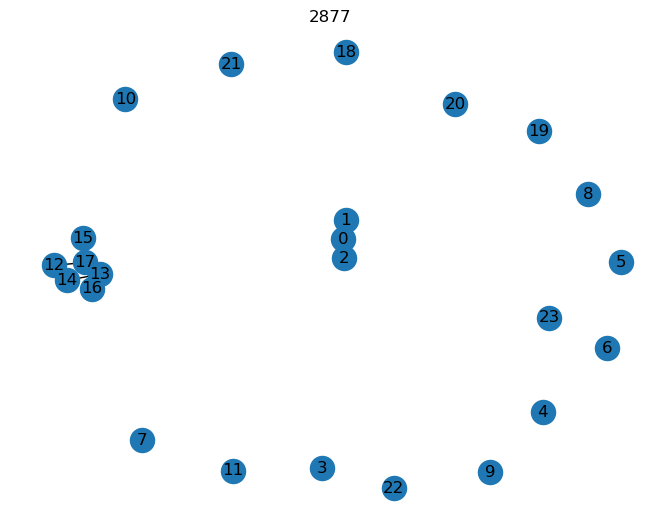

2.0
0.0
0.0
26.0
26.0
26.0
26.0
26.0
50.0
50.0
50.0
50.0
72.0
72.0
74.0
72.0
72.0
74.0
98.0
91.8
122.0
146.0
170.0
194.0


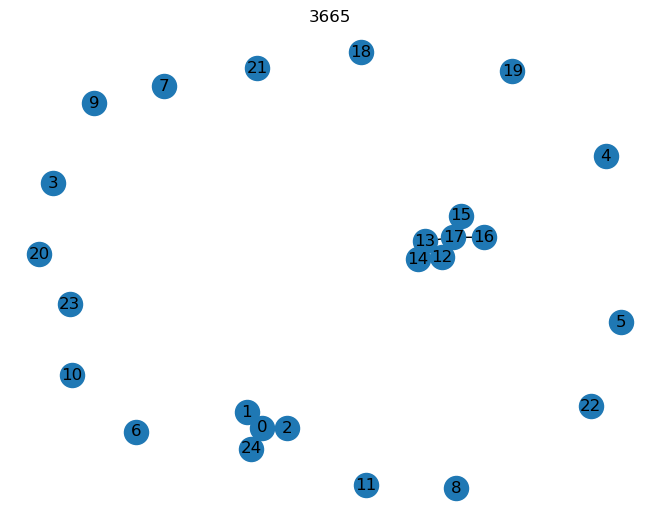

22.0
24.0
24.0
2.0
2.0
2.0
2.0
2.0
26.0
26.0
26.0
26.0
48.0
48.0
50.0
48.0
48.0
50.0
74.0
67.8
98.0
122.0
146.0
170.0
24.0


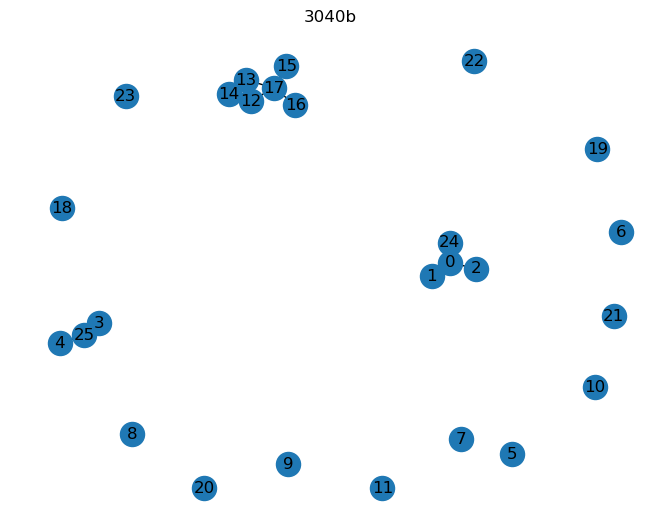

2.0
0.0
0.0
26.0
26.0
26.0
26.0
26.0
50.0
50.0
50.0
50.0
72.0
72.0
74.0
72.0
72.0
74.0
98.0
91.8
122.0
146.0
170.0
194.0
0.0
24.0


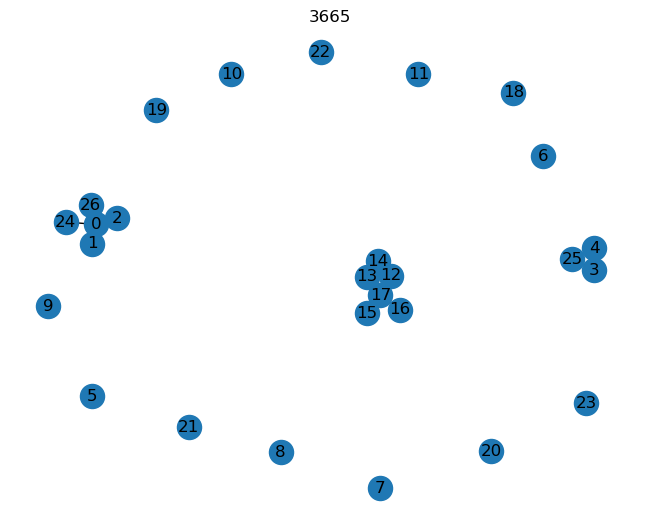

60.0
62.0
62.0
36.0
36.0
36.0
36.0
36.0
12.0
12.0
12.0
12.0
10.0
10.0
12.0
10.0
10.0
12.0
36.0
29.799999999999997
60.0
84.0
108.0
132.0
62.0
38.0
62.0


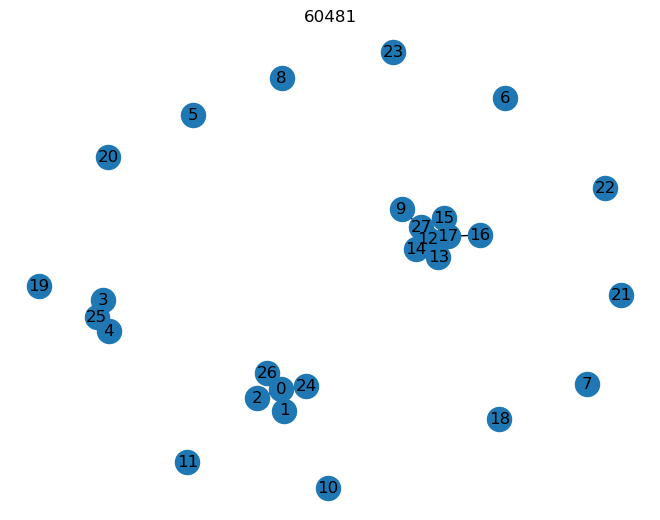

0.0
2.0
2.0
24.0
24.0
24.0
24.0
24.0
48.0
48.0
48.0
48.0
70.0
70.0
72.0
70.0
70.0
72.0
96.0
89.8
120.0
144.0
168.0
192.0
2.0
22.0
2.0
60.0


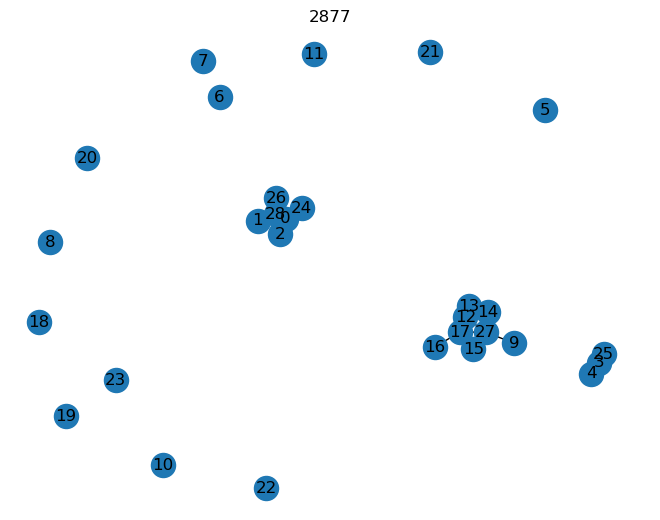

24.0
26.0
26.0
0.0
0.0
0.0
0.0
0.0
24.0
24.0
24.0
24.0
46.0
46.0
48.0
46.0
46.0
48.0
72.0
65.8
96.0
120.0
144.0
168.0
26.0
2.0
26.0
36.0
24.0


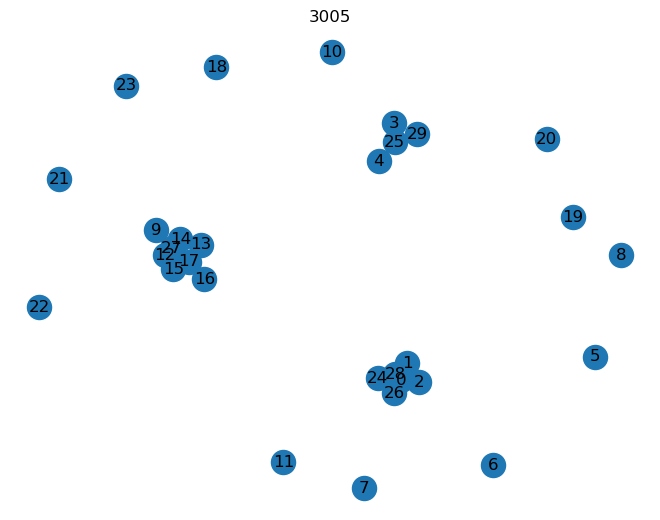

24.0
26.0
26.0
0.0
0.0
0.0
0.0
0.0
24.0
24.0
24.0
24.0
46.0
46.0
48.0
46.0
46.0
48.0
72.0
65.8
96.0
120.0
144.0
168.0
26.0
2.0
26.0
36.0
24.0
0.0


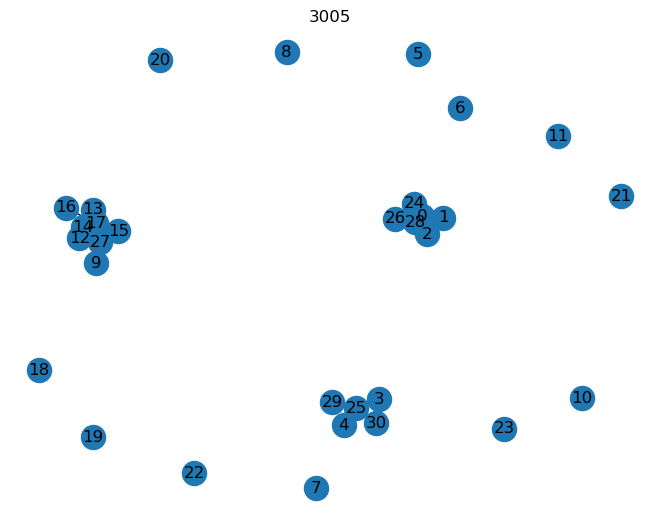

48.0
50.0
50.0
24.0
24.0
24.0
24.0
24.0
0.0
0.0
0.0
0.0
22.0
22.0
24.0
22.0
22.0
24.0
48.0
41.8
72.0
96.0
120.0
144.0
50.0
26.0
50.0
12.0
48.0
24.0
24.0


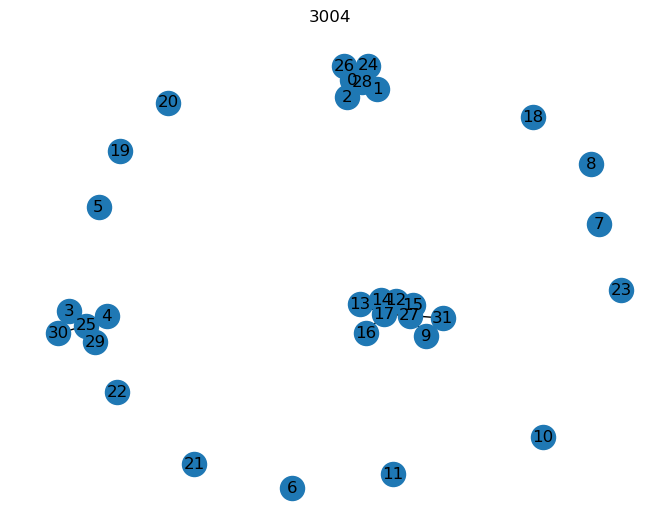

70.0
72.0
72.0
46.0
46.0
46.0
46.0
46.0
22.0
22.0
22.0
22.0
0.0
0.0
2.0
0.0
0.0
2.0
26.0
19.799999999999997
50.0
74.0
98.0
122.0
72.0
48.0
72.0
10.0
70.0
46.0
46.0
22.0


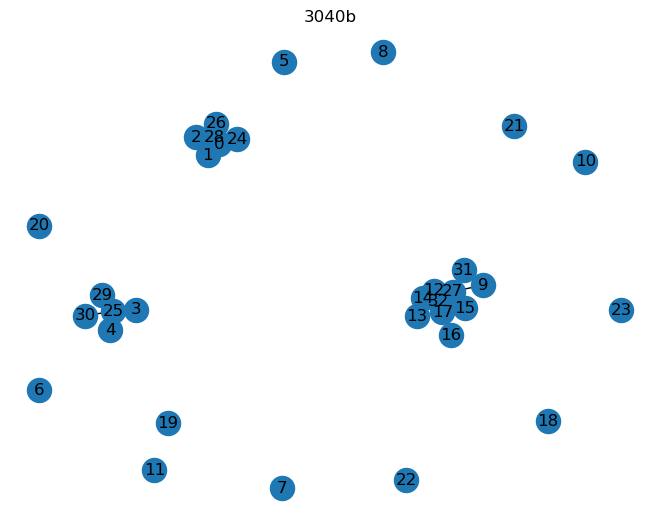

In [393]:
g = lego_network('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics_lpub3d/000012/model.ldr')

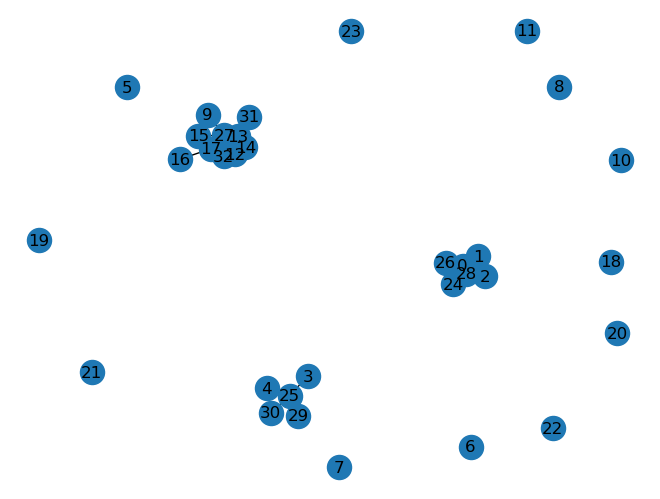

In [394]:
nx.draw(g,with_labels=True)

In [395]:
parse_ldraw_dat('/Users/glover.co/Downloads/ldraw/parts/3660a.dat')
    
    # for line in f:
        # print(line)
    

(array([[ 20.,  10.,  10.],
        [ 20., -10., -10.],
        [-20., -10., -10.],
        [-20.,  10.,  10.]]),
 [],
 [((20.0, 24.0, -10.0),
   (20.0, 4.0, -30.0),
   (-20.0, 4.0, -30.0),
   (-20.0, 24.0, -10.0))])

In [396]:
parts[parts['part_num'] == brick_names[1]]

,part_num,name,part_cat_id,part_material,x,y,z
23060,3660,"Slope Inverted 45° 2 x 2 [Ovoid Bottom Pin, Ba...",3,Plastic,2.0,2.0,1.0


In [397]:
parse_ldraw_dat('/Users/glover.co/Downloads/ldraw/parts/3003.dat')

(array([[-20.,  12.,   0.],
        [ 20.,  12.,   0.],
        [ 20., -12.,   0.],
        [-20., -12.,   0.]]),
 [],
 [((-20.0, 24.0, -20.0),
   (20.0, 24.0, -20.0),
   (20.0, 0.0, -20.0),
   (-20.0, 0.0, -20.0))])

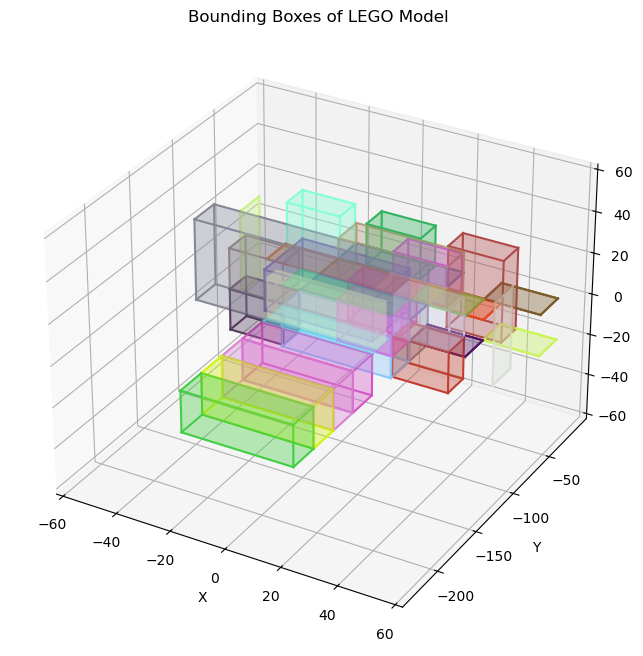

In [398]:
plot_lego_model('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics_lpub3d/000012/model.ldr')

In [374]:
parse_ldraw_dat(f'/Users/glover.co/Downloads/ldraw/parts/3660a.dat')

([(20.0, 24.0, -10.0),
  (20.0, 4.0, -30.0),
  (-20.0, 4.0, -30.0),
  (-20.0, 24.0, -10.0)],
 [],
 [((20.0, 24.0, -10.0),
   (20.0, 4.0, -30.0),
   (-20.0, 4.0, -30.0),
   (-20.0, 24.0, -10.0))])